# Toy CMB Component Separation

Astrophysical component separation is crucial to recovering accurate maps of the CMB. In this notebook, we simulate observations of the CMB + thermal dust radiation in 3 frequency bands. Then we attempt to recover the input CMB map using template fitting and ILC approaches.

In [36]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

## ipython notebook magic word to plot in the notebook
%matplotlib inline


First, we make a fake CMB map from a CMB power spectrum:

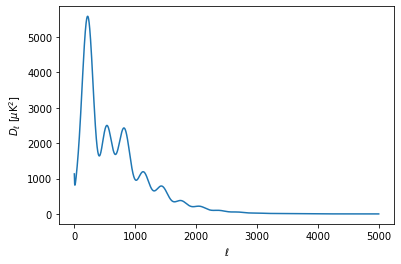

In [37]:
# read in the input CMB spectra
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()


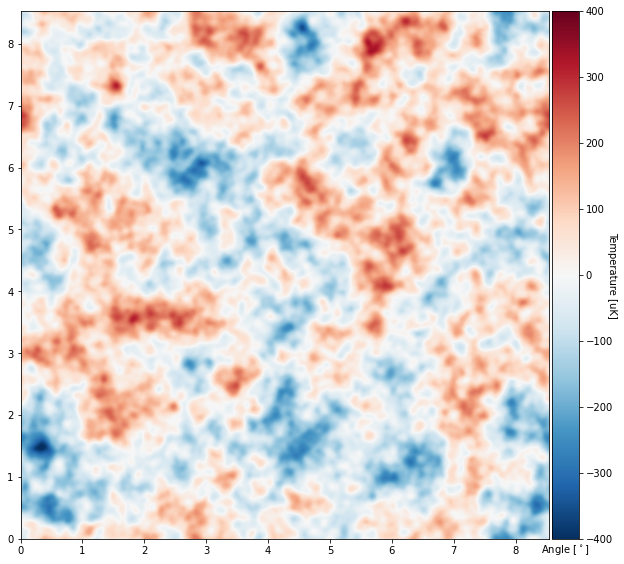

0

In [145]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
        
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('Angle $[^\circ]$')
    plt.xlabel('Angle $[^\circ]$')
    cbar.set_label('Temperature [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)

Here we create a grid of (x,y) coordinates corresponding to each pixel in the map.

In [146]:
# make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
# compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
# in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
# compute the transpose for the y dimension
Y = np.transpose(X)


# Inject in a Dust Profile at 1 Frequency

Now let's inject dust into the map. We assume a power law spatial dependence given by Planck Collaboration XXX. 2014, A&A, 571, A30.

The amplitude of the dust spectrum was chosen arbitrarily so that it competes with the CMB power spectrum.

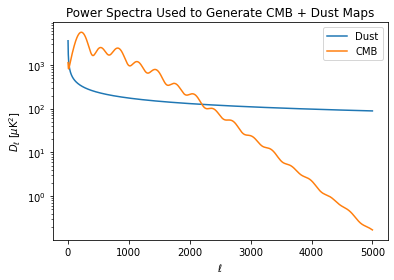

In [147]:
coeff = 2e4
Dl_dust = coeff*(ell**(-0.42)+ ell**(-1.42))/(2*np.pi)
plt.plot(ell, Dl_dust, label = 'Dust')
plt.plot(ell, DlTT, label = 'CMB')
plt.yscale('log')
plt.ylabel(r'$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel(r'$\ell$')
plt.title('Power Spectra Used to Generate CMB + Dust Maps')
plt.legend()


Create and plot a map of just the dust:

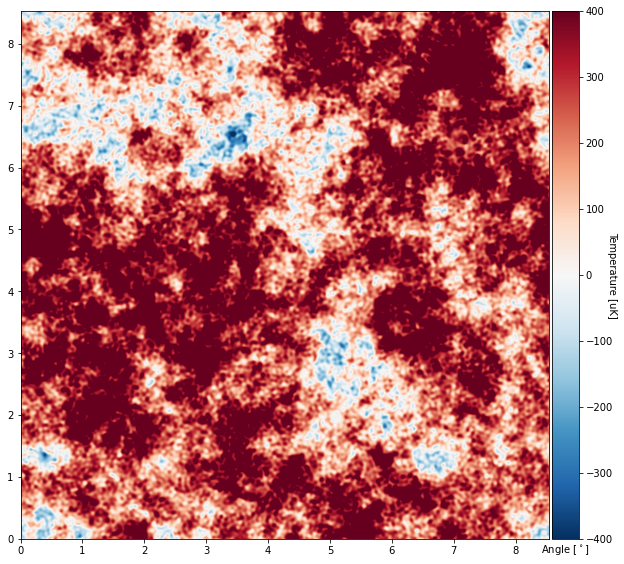

0

In [148]:
dust_scale = 5 # can adjust this to add more or less dust contamination
dust_map = dust_scale*make_CMB_T_map(N,pix_size,ell,Dl_dust)
Plot_CMB_Map(dust_map,c_min,c_max,X_width,Y_width)


Add in a "galaxy" to mimic the fact that we see much more dust in the galactic plane:

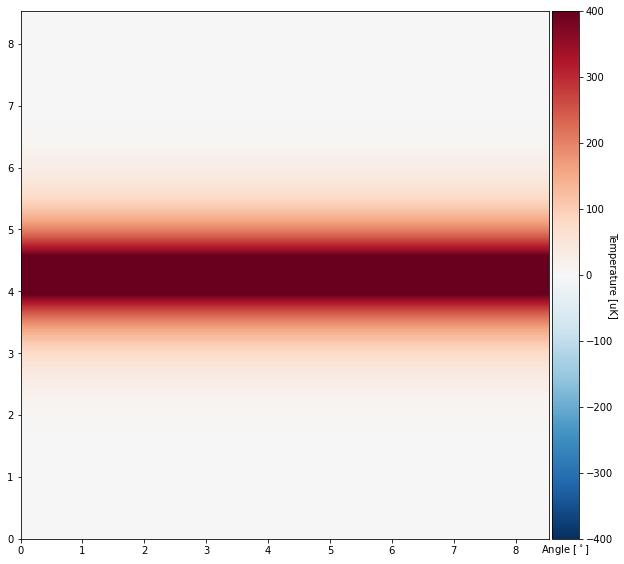

0

In [149]:
galaxy_map = 5*np.abs(8e3*(np.abs(Y) - 0.5)**6)
Plot_CMB_Map(galaxy_map, c_min, c_max, X_width, Y_width)


Plot the CMB + dust + galaxy together:

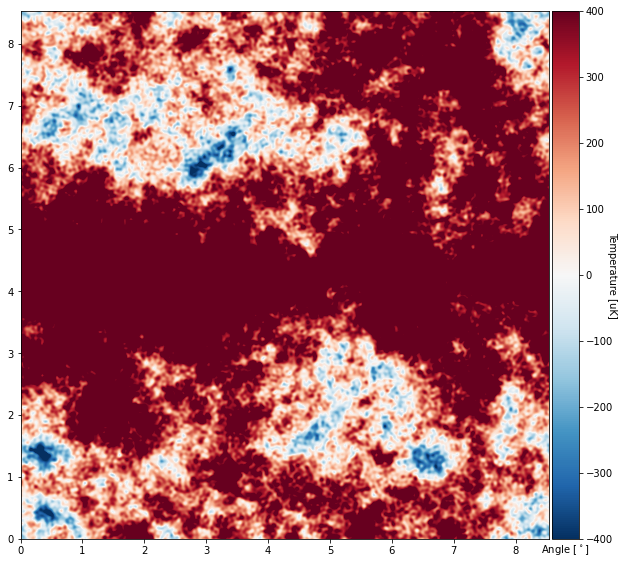

0

In [150]:
Plot_CMB_Map(CMB_T+dust_map+galaxy_map,c_min,c_max,X_width,Y_width)


## Scale the dust spectrum to different frequencies in $K_{CMB}$ units

These units are convenient because the CMB power spectrum remains constant when expressed in them.

The dust spectral dependence is given by Planck Collaboration XLVIII. 2016, A&A, 596, A109.

In [151]:
T_CMB = 2.72548
h = 6.62607015e-34
k = 1.380649e-23 
H_OVER_KT_CMB = h / k / T_CMB


In [152]:
# function to convert Rayleigh-Jeans to K_CMB power units at a particular frequency.
def rj2cmb(nu):
    x = H_OVER_KT_CMB * nu
    return (np.expm1(x)/x)**2 / np.exp(x)


In [153]:
dust_exp = 1.6  # from Planck constraints
ref_freq = 150 # in GHz
def dust_scaling(freq, dust_exp, ref_freq):
    return ((freq/ref_freq)**dust_exp)*rj2cmb(freq) # return answer in T_CMB units


In [154]:
# Here we choose 150, 220 and 280 GHz for frequency channels (this does not take into account the band shape).

dust_150 = dust_scaling(150, dust_exp, ref_freq)*(dust_map+galaxy_map)
dust_220 = dust_scaling(220, dust_exp, ref_freq)*(dust_map+galaxy_map)
dust_280 = dust_scaling(280, dust_exp, ref_freq)*(dust_map+galaxy_map)

Create simulated maps at each frequency:

In [155]:
map_150 = CMB_T + dust_150
map_220 = CMB_T + dust_220
map_280 = CMB_T + dust_280

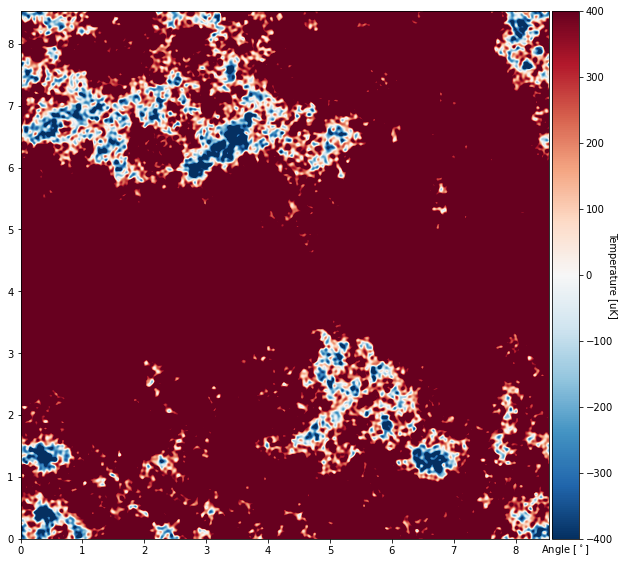

0

In [156]:
# choose the map to view below
Plot_CMB_Map(map_280,c_min,c_max,X_width,Y_width)

Our task is to recover the CMB with minimal error from these three dust-dominated maps.

Note that this is a single-component dust model; more complicated ones exist and are used in CMB analysis.

# Template Fitting

Our first approach to recovering the input CMB map is to fit a spatial dust template to the observed map and to subtract off the fitted dust map. We don't have a separate dust template, so we'll make one by subtracting the 220 GHz from the 280 GHz map, and use that to recover the CMB from the 150 GHz map.

In [157]:
from scipy.optimize import minimize


In [158]:
# make a dust template
dust_template = map_280 - map_220
# Plot_CMB_Map(dust_template,c_min,c_max,X_width,Y_width)


In [159]:
# function to fit the template to the map with a scaling coefficient c, and then subtract off the fit
def clean_with_tf(map1, template, c0):
    # function to minimize
    def template_fit_var(c):
        return np.array([np.std((map1 - c0*template)) for c0 in c])
    
    out = minimize(template_fit_var, c0, method='Powell')
    print(f'Template fit coefficient: {out.x[0]}')
    print(f'Resulting std: {out.fun}')
    return map1 - out.x*template


Template fit coefficient: 1.1948782225824954
Resulting std: 100.61425826839763


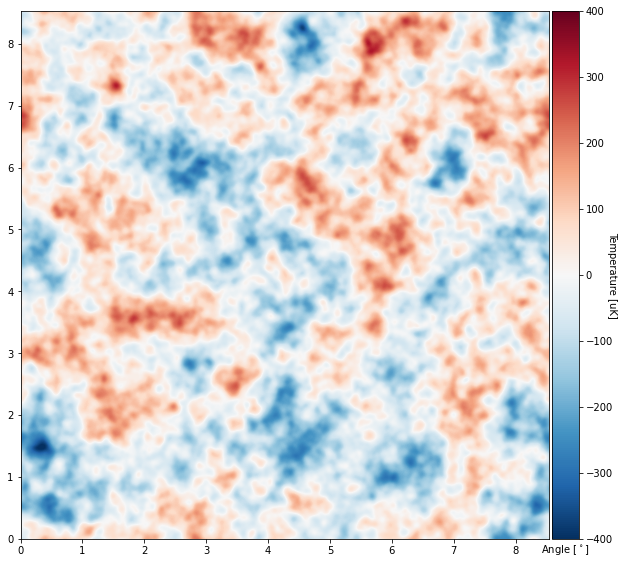

0

In [160]:
c = np.arange(0, 5, 0.001) # range of scaling fit coefficients to try
cleaned_map_tf = clean_with_tf(map_150, dust_template, 0)

# mpl.rcParams['figure.dpi'] = 300
Plot_CMB_Map(cleaned_map_tf, c_min, c_max, X_width, Y_width)


Below I plot the difference between the input and recovered CMB maps to understand the limits of our CMB reconstruction. Unsurprisingly, we see the greatest residuals in the galactic plane, where there is more dust contamination. 

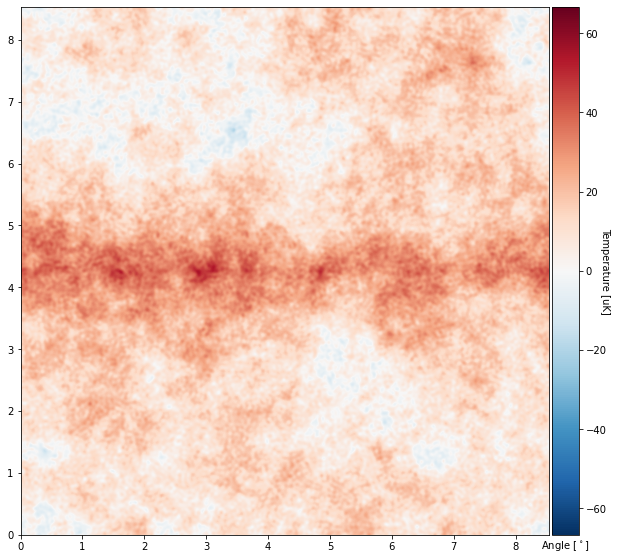

0

In [161]:
# Plot residuals: how close is the recovered CMB map to the true one?
Plot_CMB_Map(CMB_T-cleaned_map_tf, c_min/6, c_max/6, X_width, Y_width)


# Internal Linear Combination (ILC)

Internal Linear Combination (ILC) is an approach which produces weights for each observed map such that the sum of the weighted maps minimizes the contribution from anything with a different spectral dependence than the CMB. One of the strengths of this approach is that it requires no prior knowledge of foregrounds other than the fact that they do not look like a 2.7K blackbody. 

The ILC weights are given by $w^i = \frac{\sum_j C_{ij}^{-1}}{\sum_{jk} C_{jk}^{-1}}$, where $i,j,k$ span the number of maps, and $C_{ij}$ is the map-to-map covariance matrix: 

$C_{ij} = \langle \Delta T_i \Delta T_j \rangle = \frac{1}{N_p} \sum_{p=1}^{N_p} (T^i (p) - \overline{T^i})(T^j (p) - \overline{T^j}) $, where $N_p$ is the number of pixels in the map.

In [162]:
maps = [map_150, map_220, map_280]

We generate the covariance matrix, invert it, and then plug into the ILC formula to produce the weights.

In [163]:
def compute_ilc(maps):
    n = len(maps)
    N_pix = np.size(maps[0])
    
    cov = np.ones((n,n)) # build covariance matrix
    for i in range(n):
        for j in range(n):
            mean_i = np.mean(maps[i])
            mean_j = np.mean(maps[j])
            cov[i][j] = np.sum((maps[i]-mean_i)*(maps[j]-mean_j))/N_pix
            
#     inv_cov = np.linalg.inv(cov)
    u,s,v=np.linalg.svd(cov)
    inv_cov=np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))
    
    w = np.ones(n) # generate weights
    for i in range(n):
        w[i] = np.sum(inv_cov, axis=1)[i]/np.sum(inv_cov)
        
    out = np.ones(np.shape(maps[0])) # generate output map
    for i in range(n):
        out += w[i]*maps[i]
        
    return out


In [164]:
# Now apply the weights:
cleaned_map_ilc = compute_ilc(maps)


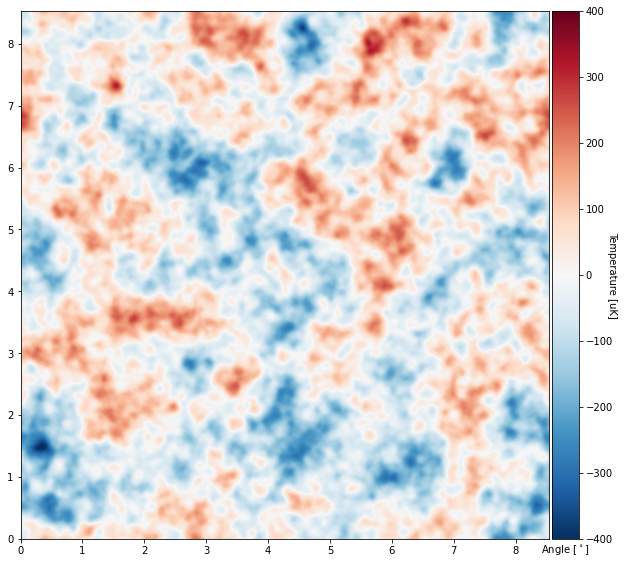

0

In [165]:
# Let's look at our ILC-cleaned map!
Plot_CMB_Map(cleaned_map_ilc, c_min, c_max, X_width, Y_width)


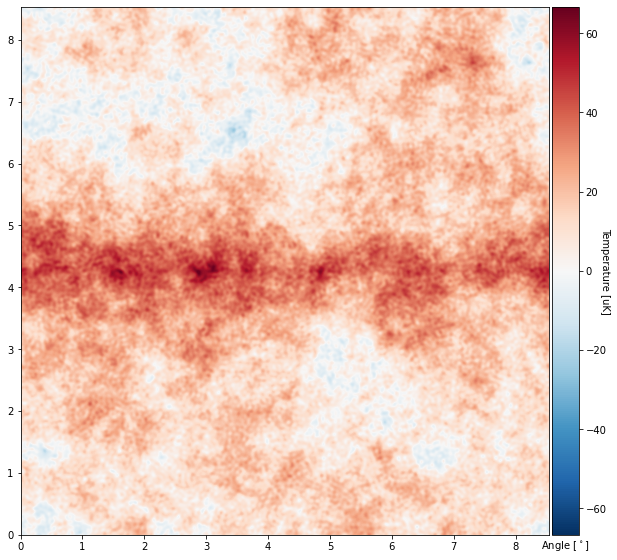

0

In [166]:
# Plot the residuals:
Plot_CMB_Map(CMB_T-cleaned_map_ilc, c_min/6, c_max/6, X_width, Y_width)


# Compute a constrained ILC

Our first ILC required no prior knowledge of the spectral or spatial properties of the foregrounds we wanted to remove. However, we do have some understanding of the spectral properties of dust. A constrained ILC can improve on our first ILC by attempting to minimize components with the dust spectral signature, which we call $b_j$.

The weights for this constrained ILC are given by

$w^i = \frac{\left(\sum_{jk} C_{jk}^{-1} b_j b_k \right) \sum_j C_{ji}^{-1} - \left(\sum_{jk} C_{jk}^{-1} b_k \right) \sum_j b_j C_{ji}^{-1}}{\left(\sum_{jk} C_{jk}^{-1} \right) \left(\sum_{jk} C_{jk}^{-1} b_j b_k \right) - \left( \sum_{jk} C_{jk}^{-1} b_k\right)^2}$

where $b_j$ is a vector describing the dust scaling across the maps.

In [167]:
# define dust scaling vector
b = [dust_scaling(nu, dust_exp, ref_freq) for nu in [150, 220, 280]]

In [168]:
# compute a constrained ILC for 1 component (in this case, dust)
def compute_constrained_ilc(maps, b):
    n = len(maps)
    N_pix = np.size(maps[0])
    
    cov = np.ones((n,n)) # build covariance matrix
    for i in range(n):
        for j in range(n):
            mean_i = np.mean(maps[i])
            mean_j = np.mean(maps[j])
            cov[i][j] = np.sum((maps[i]-mean_i)*(maps[j]-mean_j))/N_pix
            
    u,s,v=np.linalg.svd(cov)
    inv_cov=np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))
    
    w = np.ones(n) # generate weights
    
    # The weights are more complicated for the constrained ILC...
    for i in range(n):
        num = ((b@inv_cov@b)*np.sum(inv_cov, axis=0)[i]) - (np.sum(inv_cov@b)*(b@inv_cov)[i])
        denom = (np.sum(inv_cov)*(b@inv_cov@b)) - ((np.sum(inv_cov@b))**2)
        w[i] = num/denom
        
    out = np.ones(np.shape(maps[0])) # generate output map
    for i in range(n):
        out += w[i]*maps[i]
        
    return out
    

In [169]:
cleaned_map_constrained_ilc = compute_constrained_ilc(maps, b)

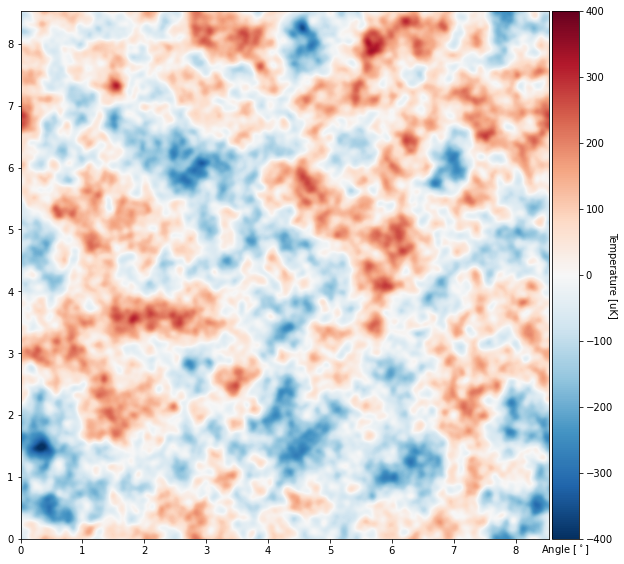

0

In [170]:
# Let's look at our constrained-ILC-cleaned map!
Plot_CMB_Map(cleaned_map_constrained_ilc, c_min, c_max, X_width, Y_width)

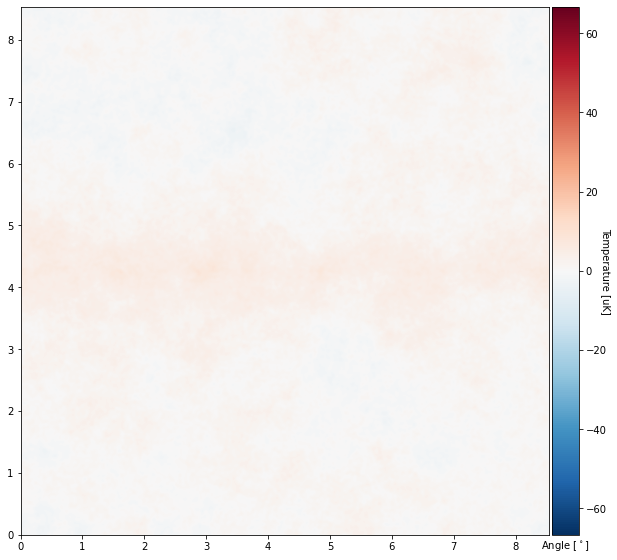

0

In [171]:
# Plot the residuals:
Plot_CMB_Map(CMB_T-cleaned_map_constrained_ilc, c_min/6, c_max/6, X_width, Y_width)

# Compare approaches by plotting residuals:

In [172]:
# Plot residuals as a function of Y:
def plot_residuals(map1, map2, label='None', absolute=False):
    # average residual per y-value
    res_per_y = np.sum(map1-map2, axis = 1)/N
    y = Y[:,0] # create array of y-values
    if (absolute):
        plt.plot(y, np.abs(res_per_y), label=label)
    else:
        plt.plot(y, res_per_y, label=label)
        

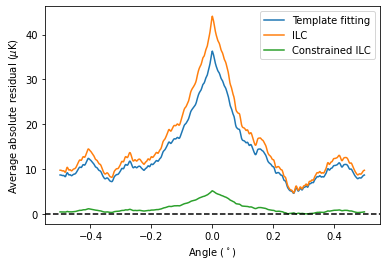

In [173]:
plot_residuals(CMB_T, cleaned_map_tf, label = 'Template fitting', absolute=True)
plot_residuals(CMB_T, cleaned_map_ilc, label = 'ILC', absolute=True)
plot_residuals(CMB_T, cleaned_map_constrained_ilc, label = 'Constrained ILC', absolute=True)


plt.axhline(y=0, color='k', linestyle='--')
plt.ylabel('Average absolute residual ($\mu$K)')
plt.xlabel('Angle ($^\circ$)')
plt.legend()


# Play with computing different ILCs for different sky regions:

Because the optimal weights to cancel out the dust (or general foreground) signal vary over different parts of the sky, we can try separating the sky into different patches and calculating an ILC for each patch. This is useful near the galaxy, but finnicky and very dependent on how you choose your patches.

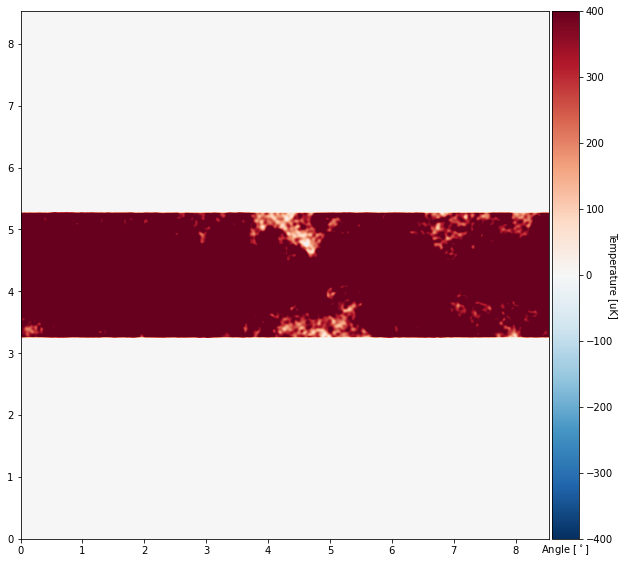

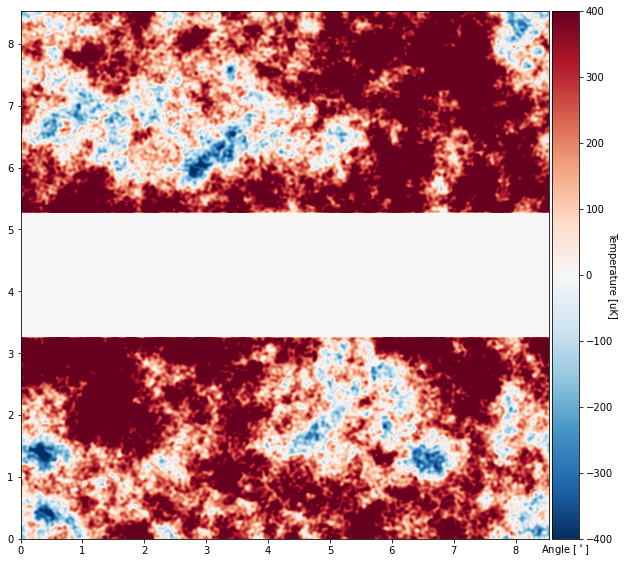

0

In [174]:
threshold = 0.2 # you can adjust this and see how it affects the residuals

# create two masks which separate the sky into a galaxy and a non-galaxy patch
galaxy_mask = (galaxy_map/np.max(galaxy_map) > threshold).astype('int')
no_galaxy_mask = (galaxy_map/np.max(galaxy_map) < threshold).astype('int')

Plot_CMB_Map(map_150*galaxy_mask, c_min, c_max, X_width, Y_width)
Plot_CMB_Map(map_150*no_galaxy_mask, c_min, c_max, X_width, Y_width)


In [175]:
# apply the masks to create the two patches
maps_with_gal = [m*galaxy_mask for m in maps]
maps_without_gal = [m*no_galaxy_mask for m in maps]

In [176]:
cleaned_map_ilc_split = compute_ilc(maps_with_gal) + compute_ilc(maps_without_gal)
cleaned_map_constrained_ilc_split = compute_constrained_ilc(maps_with_gal, b) + compute_constrained_ilc(maps_without_gal, b)

Finally, let's look at the residuals...

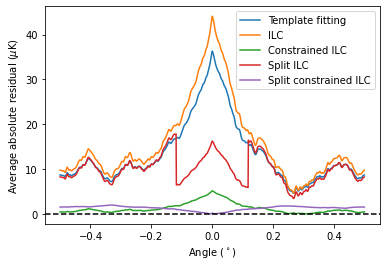

In [177]:
plot_residuals(CMB_T, cleaned_map_tf, label = 'Template fitting', absolute=True)
plot_residuals(CMB_T, cleaned_map_ilc, label = 'ILC', absolute=True)
plot_residuals(CMB_T, cleaned_map_constrained_ilc, label = 'Constrained ILC', absolute=True)
plot_residuals(CMB_T, cleaned_map_ilc_split, label = 'Split ILC', absolute=True)
plot_residuals(CMB_T, cleaned_map_constrained_ilc_split, label = 'Split constrained ILC', absolute=True)

plt.axhline(y=0, color='k', linestyle='--')
plt.ylabel('Average absolute residual ($\mu$K)')
plt.xlabel('Angle ($^\circ$)')
plt.legend()
